In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [2]:
df = pd.read_csv('Data.csv', encoding='cp1250')

In [3]:
df.columns

Index(['Kód okresu', 'Název okresu', 'Věk', 'Pohlaví', 'Rodinný stav',
       'Nejvyšší dosažené vzdělání', 'Počet osob'],
      dtype='object')

In [4]:
df.head()

,Kód okresu,Název okresu,Věk,Pohlaví,Rodinný stav,Nejvyšší dosažené vzdělání,Počet osob
0,CZ0201,Benešov,0,muž,Svobodný/svobodná,nedefinováno - osoby ve věku 0–14 let,507
1,CZ0201,Benešov,0,žena,Svobodný/svobodná,nedefinováno - osoby ve věku 0–14 let,504
2,CZ0201,Benešov,1,muž,Svobodný/svobodná,nedefinováno - osoby ve věku 0–14 let,513
3,CZ0201,Benešov,1,žena,Svobodný/svobodná,nedefinováno - osoby ve věku 0–14 let,538
4,CZ0201,Benešov,2,muž,Svobodný/svobodná,nedefinováno - osoby ve věku 0–14 let,565


In [5]:
df.dtypes

Kód okresu                    object
Název okresu                  object
Věk                           object
Pohlaví                       object
Rodinný stav                  object
Nejvyšší dosažené vzdělání    object
Počet osob                     int64
dtype: object

In [6]:
df['Nejvyšší dosažené vzdělání'].unique()

array(['nedefinováno - osoby ve věku 0–14 let', 'bez vzdělání',
       'nedokončené základní vzdělání', 'základní vzdělání', 'nezjištěno',
       'střední nebo vyučení (bez maturity)',
       'úplné střední všeobecné (s maturitou)',
       'úplné střední odborné (s maturitou)', 'konzervatoř',
       'nástavbové/zkrácené studium, absolvování dvou a více oborů středních škol',
       'pomaturitní studium', 'bakalářské', 'vyšší odborné vzdělání',
       'magisterské', 'doktorské'], dtype=object)

# Pohlaví - vzdělání

In [7]:
df.groupby('Pohlaví')

In [8]:
df.shape

(404968, 7)

In [9]:
def split_by(df: pd.DataFrame, column: str) -> list:
    return [df[df[column] == column_type]['Věk'] for column_type in df[column].unique()]

In [10]:
def convert_age_to_int(s: str) -> int:
    return 100 if s.endswith('+') else int(s)
df['Věk'] = df['Věk'].apply(convert_age_to_int)

In [11]:
education = pd.DataFrame(columns=['Věk', 'Pohlaví', 'Vysokoškolsky vzdělaný', 'Počet osob', 'Poměr vzdělaných'])
for age in df['Věk'].unique():
    df_age = df[df['Věk'] == age]
    for gender in ('muž', 'žena'):
        df_gender = df_age[df_age['Pohlaví'] == gender]
        total = df_gender['Počet osob'].astype(int).sum()
        educated = df_gender[df_gender['Nejvyšší dosažené vzdělání'].isin(['bakalářské', 'vyšší odborné vzdělání', 'magisterské', 'doktorské'])]['Počet osob'].astype(int).sum()
        percentage_educated = educated / total * 100
        new_row = pd.DataFrame([[age, gender, educated, total, percentage_educated]], columns = education.columns)
        if education.empty:
            education = new_row
        else:
            education = pd.concat([education, new_row])

df_edu = education.pivot(index = 'Věk', columns = 'Pohlaví', values = 'Vysokoškolsky vzdělaný')
df_pop = education.pivot(index = 'Věk', columns = 'Pohlaví', values = 'Počet osob')
df_perc = education.pivot(index = 'Věk', columns = 'Pohlaví', values = 'Poměr vzdělaných')

C:\Users\svest\AppData\Local\Temp\ipykernel_1376\3651196559.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


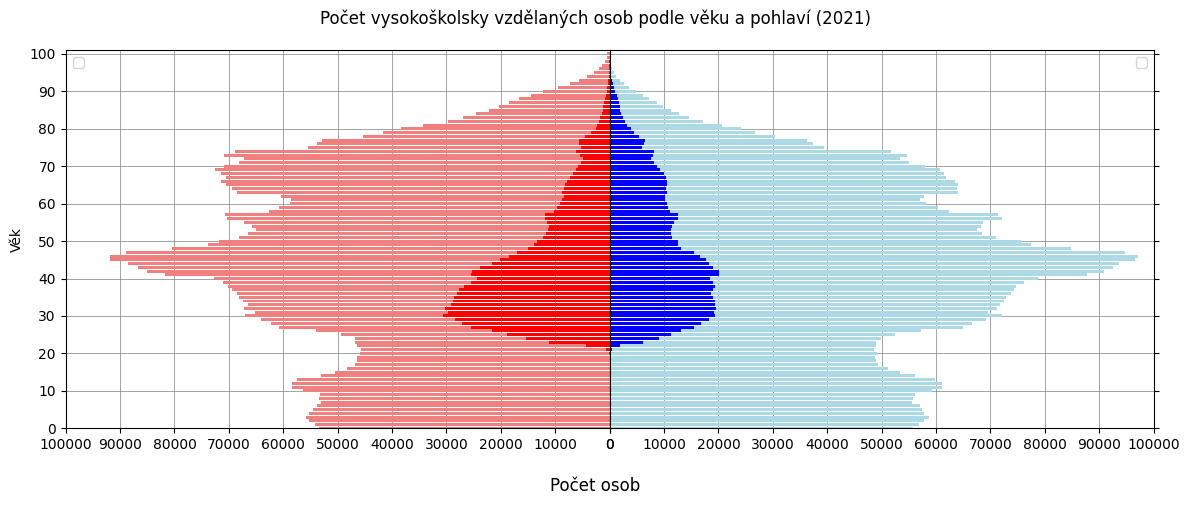

In [12]:
ages = df_edu.index
male = df_edu.get('muž')
female = df_edu.get('žena')
male_pop = df_pop.get('muž')
female_pop = df_pop.get('žena')
y = np.arange(len(ages))
height = 0.8
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True, gridspec_kw={'wspace': 0})

max_pop = 100000
locator = ticker.MultipleLocator(10000)
xticks = np.arange(0, max_pop+1, 10000)
yticks = np.arange(0, 101, 10)
fmt = ticker.FuncFormatter(lambda x, pos: f"{abs(int(x)):,}")

# Both
for ax in (ax1, ax2):
    ax.set_ylim(0, 101)
    ax.set_yticks(yticks)
    ax.set_axisbelow(True)       
    ax.grid(axis='x', color='gray', linewidth=0.5)
    ax.grid(axis='y', color='gray', linewidth=0.5)
    ax.legend()


# Plot left
ax1.barh(y = y, width = -female_pop, height = height, label = 'ženy', color = 'lightcoral')
ax1.barh(y = y, width = -female, height = height, label = 'ženy - vysokoškolsky vzdělané', color = 'red')

ax1.set_xlim(-max_pop, 0)
ax1.set_xticks(-xticks)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: abs(int(x))))

ax1.set_ylabel('Věk')



# Plot right
ax2.barh(y = y, width = male_pop, height = height, label = 'muži', color = 'lightblue')
ax2.barh(y = y, width = male, height = height, label = 'muži - vysokoškolsky vzdělaní', color = 'blue')

ax2.set_xlim(0, max_pop)
ax2.set_xticks(xticks)

ax2.yaxis.tick_right()


# Both
fig.suptitle("Počet vysokoškolsky vzdělaných osob podle věku a pohlaví (2021)")
fig.supxlabel("Počet osob")

plt.tight_layout()
plt.show()

fig.savefig(
    "populace_vzdelani.pdf",
    format="pdf",
    bbox_inches="tight"
)

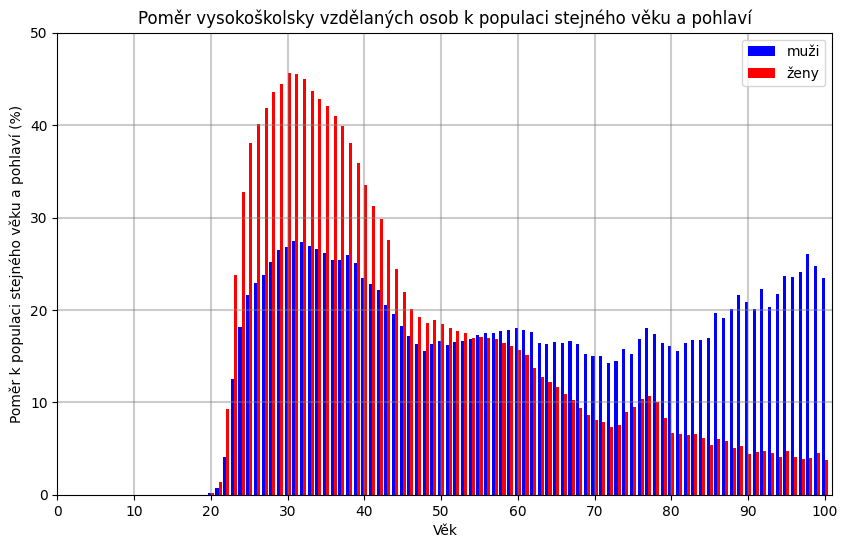

In [13]:
ages = df_perc.index
male = df_perc.get('muž')
female = df_perc.get('žena')
x = np.arange(len(ages))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 6))
xticks = np.arange(0, 101, 10)

ax.hlines(np.arange(10, 100, 10), xmin = 0, xmax = 200, color = 'grey', alpha = 0.4)
ax.bar(x = x - width / 2, height = male, width = width, label = 'muži', color = 'blue')
ax.bar(x = x + width / 2, height = female, width = width, label = 'ženy', color = 'red')

ax.set_xlim(0, 101)
ax.set_xlabel('Věk')
ax.set_xticks(xticks)
ax.vlines(np.arange(10, 100, 10), ymin = 0, ymax = 200, color = 'grey', alpha = 0.4)

ax.set_ylim(0, 50)
ax.set_ylabel('Poměr k populaci stejného věku a pohlaví (%)')

ax.set_title('Poměr vysokoškolsky vzdělaných osob k populaci stejného věku a pohlaví')
ax.legend()
plt.show()

fig.savefig(
    "pomer_populace_vzdelani.pdf",
    format="pdf",
    bbox_inches="tight"
)